In [1]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import torch
from torch import nn
import pickle
import textwrap
from math import ceil
import tqdm.auto as tqdm


import sklearn as sk
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

import confseq
from confseq import predmix, conjmix_bounded, betting

from Energy_ds.dataset import DataPrep, DataModule, EnergyDataset
from Energy_ds.config import SEASON, REGION, DatasetConfig

from neural.train import LightningTrainer
from neural.module import LightningModel, LightningWrapper
from neural.mlp import MlpBlock, RMLP, MLPLayer
from neural.config import TrainConfig

from risk import *
from algorithm import Hypothesis, ConfSeq

pd.set_option('display.max_columns', None)
sns.set_palette('viridis')


In [2]:
class SubplotGenerator:
    def __init__(self, rows, columns, dpi=200, **kwargs):
        self.fig, self.axes = plt.subplots(rows, columns, dpi=dpi, **kwargs)
        self.rows = rows
        self.columns = columns
        self.current_row = 0
        self.current_col = 0

    def __iter__(self):
        self.current_row = 0
        self.current_col = 0
        return self

    def __next__(self) -> plt.Axes:
        if self.current_row >= self.rows:
            raise StopIteration
        ax = self.axes[self.current_row, self.current_col]
        self.current_col += 1
        if self.current_col >= self.columns:
            self.current_col = 0
            self.current_row += 1
        return ax
    
    @property
    def current_ax(self) -> plt.Axes:
        return self.axes[self.current_row, self.current_col]

In [3]:
class HoffConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = predmix.predmix_hoeffding_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    
    @staticmethod
    def standardise(x):
        return (x - x.min()) / (x.max() - x.min())
    

class EmpbernConf(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val=min_val, max_val=max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)

        lower_cs, higher_cs = predmix.predmix_empbern_twosided_cs(x, self.conf_lvl, running_intersection=False)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    

class EmpbernConjmix(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        # std = x.std()
        lower_cs, higher_cs = conjmix_bounded.conjmix_empbern_twosided_cs(x, 1/12, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs


class EmpbernBetting(ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = betting.betting_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

In [4]:
class H0(Hypothesis):
    def __init__(self, tolerance:float, lower_bound:ConfSeq, upper_bound:ConfSeq):
        super().__init__(tolerance, lower_bound, upper_bound)
    
    @property
    def source_upper(self):
        return self.source_upper_cs[-1] * self.tolerance
    
    @property
    def target_lower(self):
        return self.target_lower_cs
    


In [5]:
class DeployedModel:
    def __init__(
        self,
        model: RandomForestRegressor,
        hyp_tests: list[tuple[Hypothesis, Risk]],
        past:int=np.inf
    ):
        self.model = model
        self.hyp_tests = hyp_tests
        self.past = past
        
        self.input_seq = None
        self.label_seq = None
        self.pred_seq = None

        self.collector:tuple[Hypothesis, Risk] = None
        self.retrainer:tuple[Hypothesis, Risk] = None
        self.collect_from_idx:int = None
        # self.min_retrain_hours = 24*7*3 # 3 is hardcoded number of regions...

        self.train_features = None
        self.train_labels = None
        self.sample_weights = None
        self.retrain:bool = True
        self.retrain_intervals:list[tuple[int, int]] = []

    def update(self, features:np.ndarray, labels: np.ndarray, to_target:bool=True) -> None:
        # features = features.reshape(-1, 1)
        preds = self.model.predict(features)
        # update input, label and prediction sequences
        self.input_seq = self._append_seq(features, self.input_seq)
        self.label_seq = self._append_seq(labels, self.label_seq)
        self.pred_seq = self._append_seq(preds, self.pred_seq)
        
        past = max(len(self.input_seq) - self.past, 0)
        tr_input, tr_label, tr_pred, = self.input_seq[past:], self.label_seq[past:], self.pred_seq[past:]
        # update targed confidence bounds
        for hyp, risk in self.hyp_tests:
            val = risk(tr_input, tr_label, tr_pred)
            if not np.isnan(val): # ignore nan values
                hyp.add_observations(val, to_target=to_target)
                # hyp.test(val) # same results without testing every time
        
        if to_target and self.retrain:
            if self.collector is not None and self.collect_from_idx is None:            
                hyp, risk = self.collector
                valid = hyp.test()
                if not valid:
                    self.collect_from_idx = len(self.input_seq)
                    print(f"Collecting from index: {self.collect_from_idx}")
            
            if self.retrainer is not None and self.collect_from_idx is not None:
                if len(self.input_seq) - self.collect_from_idx >= 2*self.past:
                    hyp, risk = self.retrainer
                    valid = hyp.test()
                    if not valid: # crossed the second threshold
                        print("retrain threshold crossed at index: ", len(self.input_seq))                        
                        x, y = self.input_seq[self.collect_from_idx:], self.label_seq[self.collect_from_idx:]
                        self.train_features = self._append_seq(x, self.train_features, dim=0)
                        self.train_labels = self._append_seq(y, self.train_labels, dim=0)
                        
                        # calculate new sample weights
                        sample_weights = self.sample_weights.copy() * 0.5
                        self.sample_weights = np.ones(len(self.train_labels))
                        self.sample_weights[:len(sample_weights)] = sample_weights

                        # n_estimators = self.model.get_params()['n_estimators'] + 1 #ceil(np.log10(len(y)))
                        # self.model.set_params(n_estimators=n_estimators)
                        # print(f"New n_estimators: {n_estimators}")
                        # self.model.set_params(max_iter=250)
                        # self.model = self.model.fit(x,y)
                        # self.model.set_params(learning_rate_init=0.0005, max_iter=150, warm_start=True)
                        self.fit()
                        self.retrain_intervals.append((self.collect_from_idx, len(self.input_seq)))
                        self.collect_from_idx = None
                        print("Retrained Model with new data ")

    def test(self):
        test_results = []
        for hyp, _ in self.hyp_tests:
            res = hyp.test()
            test_results.append(res)
        return all(test_results)

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, train_ds:EnergyDataset|None=None):
        # fit model
        if train_ds is not None:
            x, y = train_ds.features, train_ds.labels
            self.train_features = x
            self.train_labels = y
            self.sample_weights = np.ones(len(y))
        else:
            x, y = self.train_features, self.train_labels
        
        # mask = self.sample_weights > 0.3 ** 4
        # x, y = x[mask], y[mask]
        print(f"train_features shape: {x.shape}, train_labels shape: {y.shape}")
        self.model = self.model.fit(x, y)
    
    def calibrate(self, calibration_ds:EnergyDataset, batch_size:int=1):
        calibration_ds.set_batch_size(batch_size)
        for batch_idx, (x, y) in enumerate(calibration_ds):
            self.update(x, y, to_target=False)

        for hyp, risk in self.hyp_tests:
            risk_list = hyp.source_bound._risk_seq
            min_val, max_val = self.infer_bounds(hyp, risk_seq=risk_list, gamma=5, set_bounds=True)
            print(f"Inferred {risk} Bounds: min_val: {min_val}, max_val: {max_val} :: risk mean: {risk_list.mean()}, std: {risk_list.std()}")
            hyp.calc_source_upper_cs(risk_list)
        
    def set_retraining_tests(self, collector:tuple[Hypothesis, Risk], retrainer:tuple[Hypothesis, Risk]):
        self.collector = collector
        self.retrainer = retrainer
        self.collect_from_idx = None

        self.hyp_tests.append(collector)
        self.hyp_tests.append(retrainer)

    def to_dataframe(self):
        results = []
        for hyp, risk in self.hyp_tests:
            res = hyp.to_dataframe()
            # res['GT'] = self.label_seq
            res['risk'] = risk.__class__.__name__
            res['hyp'] = hyp.__class__.__name__
            results.append(res)
        return pd.concat(results, axis=0, ignore_index=True)
    
    def _append_seq(self, x:np.ndarray|float, seq:np.ndarray, dim:int=0) -> np.ndarray:
        """
        append the input x to the sequence.
        parameters:
            x (np.ndarray): The input array of shape (n_samples) or a float if x is a single sample.
            seq (np.ndarray): The sequence to append to.
        """
        if isinstance(x, float):
            x = np.asanyarray([x])
        
        if seq is None:
            return x

        new_seq = np.concatenate((seq, x), axis=dim)
        return new_seq

    def reset(self, source:bool=True, target:bool=True):
        if target:
            self.input_seq = None
            self.label_seq = None
            self.pred_seq = None

        for hyp, risk in self.hyp_tests:
            hyp.reset(source=source, target=target)
        
    def infer_bounds(self, hyp:Hypothesis, risk_seq:np.ndarray, gamma:float=2, set_bounds:bool=False):
        std = (risk_seq).std()

        min_val = risk_seq.min() - std * gamma
        min_val = max(min_val, 0)
        max_val = risk_seq.max() + std * gamma

        if set_bounds:
            # print(f"Setting Bounds: min_val: {min_val}, max_val: {max_val}")
            hyp.set_bounds(min_val, max_val)
        
        return min_val, max_val
    

In [6]:
class Experiment:
    def __init__(
        self,
        model,
        batch_size=1, # in hours (will load n_regions * batch_size)
        test_every=1, # calculate confidence intervals and test hypotheses every n batches
    ):
        self.model: DeployedModel = model
        self.batch_size: int = batch_size
        self.test_every: int = test_every

    def train(self, train_ds: EnergyDataset):
        self.model.fit(train_ds)
    
    def calibrate(self, calibration_ds: EnergyDataset):
        self.model.calibrate(calibration_ds, batch_size=self.batch_size)
    
    def eval(self, val_ds: EnergyDataset):
        preds = self.model.predict(val_ds.features)
        mse = sk.metrics.mean_squared_error(val_ds.labels, preds)
        mae = sk.metrics.mean_absolute_error(val_ds.labels, preds)
        return mse, mae

    def test(self, test_ds: EnergyDataset):
        test_ds.set_batch_size(self.batch_size)
        ds_len = ceil(len(test_ds) / test_ds.batch_size)
        for batch_idx, (x, y) in tqdm.tqdm(enumerate(test_ds), desc="Testing", total=ds_len):
            self.model.update(x, y)
            # if batch_idx % self.test_every == 0:
            #     self.model.test()
        self.model.test()
        return self.model.to_dataframe()

In [7]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
all_paths = ['Hourly_Energy_Consumption/AEP_hourly.csv',
            'Hourly_Energy_Consumption/COMED_hourly.csv',
            'Hourly_Energy_Consumption/DAYTON_hourly.csv',
            'Hourly_Energy_Consumption/DEOK_hourly.csv',
            'Hourly_Energy_Consumption/DOM_hourly.csv',
            'Hourly_Energy_Consumption/DUQ_hourly.csv',
            'Hourly_Energy_Consumption/EKPC_hourly.csv',
            'Hourly_Energy_Consumption/FE_hourly.csv',
            'Hourly_Energy_Consumption/NI_hourly.csv',
            'Hourly_Energy_Consumption/PJME_hourly.csv',
            'Hourly_Energy_Consumption/PJMW_hourly.csv',
            # 'Hourly_Energy_Consumption/PJM_Load_hourly.csv',
            # 'Hourly_Energy_Consumption/est_hourly.paruqet',
            # 'Hourly_Energy_Consumption/pjm_hourly_est.csv'
            ]

# Analyze Data

In [8]:
# prep = DataPrep(*all_paths)
# data = prep.data

In [9]:
# data['Region'] = data['Region'].apply(lambda x: REGION(x).name)
# data['Epoch'] = data['Datetime'].apply(lambda x: x.timestamp())
# grouped = data.groupby(by=['Region']).agg(['min', 'max', 'mean', 'std'])
# grouped


In [10]:
# g = sns.relplot(data=data, x='Datetime', y='MW', hue='Region', kind='line', aspect=3, linewidth = 0.8)
# g.figure.suptitle(template=f"Energy Consumption in each region, by season")
# g.figure.set_dpi(200)

![Dataset Visualization](/home/guycoh/new/ReliabilityInML_Project/imgs/dataset_vis.png)

# Run Experiments

In [11]:
train_config = DatasetConfig(
    past_hours=[1,2,3,6, 12, 24, 36],
    years=(2012, 2014),
    region=[REGION.AEP, REGION.COMED, REGION.DOM],
    # season=None,
)


calibration_config = DatasetConfig(**train_config.__dict__)
calibration_config.years = (2014, 2015)


In [12]:
train_ds = EnergyDataset(all_paths, train_config)
data = pd.concat([train_ds.features_df, train_ds.labels_df], axis=1)
data['Season'] = data['Season'].apply(lambda x: SEASON(x).name)
data['Region'] = data['Region'].apply(lambda x: REGION(x).name)

calibration_ds = EnergyDataset(all_paths, calibration_config)

columns = train_ds.features_df.columns

In [13]:
data.describe()

Year         Month           Day          Hour  Week_Number  \
count  52619.000000  52619.000000  52619.000000  52619.000000      52619.0   
mean    2012.499325      6.519622     15.740892     11.502195    26.464566   
std        0.500004      3.449391      8.803838      6.921691     15.06578   
min     2012.000000      1.000000      1.000000      0.000000          1.0   
25%     2012.000000      4.000000      8.000000      6.000000         13.0   
50%     2012.000000      7.000000     16.000000     12.000000         26.0   
75%     2013.000000     10.000000     23.000000     18.000000         40.0   
max     2013.000000     12.000000     31.000000     23.000000         52.0   

          MW_at_-1H     MW_at_-2H     MW_at_-3H     MW_at_-6H    MW_at_-12H  \
count  52619.000000  52619.000000  52619.000000  52619.000000  52619.000000   
mean    7943.056443  13011.726772  16977.869933  14997.962903  15784.774986   
std     5493.323136  13722.530068  11187.536905  12801.020825  12128.722028   
min     1655.000000   1154.000000   4994.000000   1155.000000   1167.000000   
25%     3395.000000   2205.000000   8361.500000   3178.500000   6869.000000   
50%     5413.000000   5413.000000  11379.000000  10408.000000  10314.000000   
75%    13564.000000  27217.000000  27217.000000  27217.000000  27216.500000   
max    23320.000000  59122.000000  59122.000000  59122.000000  59122.000000   

         MW_at_-24H    MW_at_-36H            MW  
count  52619.000000  52619.000000  52619.000000  
mean   12957.444098  13244.334632  12538.654079  
std    11400.373121   7855.576965   3081.219186  
min      514.000000   1155.000000   6287.000000  
25%     3178.000000   9555.500000  10158.000000  
50%     9596.000000  11807.000000  12059.000000  
75%    17691.500000  15179.000000  14645.000000  
max    58999.000000  59122.000000  23603.000000

In [14]:
train_ds.features_df.head(40)

Region  Year  Month  Day  Hour  Week_Number  Season  MW_at_-1H  MW_at_-2H  \
0        1  2012      1    1     0           52       4     4910.0    28107.0   
1        2  2012      1    1     0           52       4    14181.0     4910.0   
2        5  2012      1    1     0           52       4     1655.0    10335.0   
3        1  2012      1    1     1           52       4     4723.0    26949.0   
4        2  2012      1    1     1           52       4    13812.0     4723.0   
5        5  2012      1    1     1           52       4     2533.0     1605.0   
6        1  2012      1    1     2           52       4     4540.0    25727.0   
7        2  2012      1    1     2           52       4    13662.0     4540.0   
8        5  2012      1    1     2           52       4     2465.0     1555.0   
9        1  2012      1    1     3           52       4     4407.0    24710.0   
10       2  2012      1    1     3           52       4    13517.0     4407.0   
11       5  2012      1    1     3           52       4     2364.0     1507.0   
12       1  2012      1    1     4           52       4     4324.0    23908.0   
13       2  2012      1    1     4           52       4    13465.0     4324.0   
14       5  2012      1    1     4           52       4     2313.0     1483.0   
15       1  2012      1    1     5           52       4     4297.0    23589.0   
16       2  2012      1    1     5           52       4    13561.0     4297.0   
17       5  2012      1    1     5           52       4     2279.0     1457.0   
18       1  2012      1    1     6           52       4     4353.0    23687.0   
19       2  2012      1    1     6           52       4    13623.0     4353.0   
20       5  2012      1    1     6           52       4     2269.0     1471.0   
21       1  2012      1    1     7           52       4     4476.0    24140.0   
22       2  2012      1    1     7           52       4    13806.0     4476.0   
23       5  2012      1    1     7           52       4     2304.0     1497.0   
24       1  2012      1    1     8           52       4     4638.0    25019.0   
25       2  2012      1    1     8           52       4    13981.0     4638.0   
26       5  2012      1    1     8           52       4     2345.0     1551.0   
27       1  2012      1    1     9           52       4     4814.0    25601.0   
28       2  2012      1    1     9           52       4    14208.0     4814.0   
29       5  2012      1    1     9           52       4     2357.0     1547.0   
30       1  2012      1    1    10           52       4     4941.0    26226.0   
31       2  2012      1    1    10           52       4    14304.0     4941.0   
32       5  2012      1    1    10           52       4     2420.0     1589.0   
33       1  2012      1    1    11           52       4     4994.0    26431.0   
34       2  2012      1    1    11           52       4    14155.0     4994.0   
35       5  2012      1    1    11           52       4     2473.0     1637.0   
36       1  2012      1    1    12           52       4     4985.0    26576.0   
37       2  2012      1    1    12           52       4    14183.0     4985.0   
38       5  2012      1    1    12           52       4     2547.0     1719.0   
39       1  2012      1    1    13           52       4     4974.0    26720.0   

    MW_at_-3H  MW_at_-6H  MW_at_-12H  MW_at_-24H  MW_at_-36H  
0      6832.0     1707.0      1644.0     15321.0      1765.0  
1     28107.0     9487.0      7085.0     11542.0      7785.0  
2     14181.0     6832.0      5129.0     10050.0      5729.0  
3      6550.0     1655.0      1569.0     14867.0      1737.0  
4     26949.0     9225.0      6832.0     11149.0      7550.0  
5      9906.0    26949.0     14181.0      1644.0     15321.0  
6      6227.0     2533.0      6550.0     10855.0      7309.0  
7     25727.0     9010.0     26949.0      1707.0     30628.0  
8      9407.0    25727.0      9906.0      6832.0     11149.0  
9      5955.0     2465.0      6227.0      1655.0    

In [15]:
# g = sns.relplot(data=data, x='Hour', y='MW', hue='Season', col='Year', row='Region', kind='line', palette='viridis')
# g.figure.suptitle(f"Energy Consumption By Hour, per year and region", fontsize=16)
# g.figure.set_dpi(200)
# g.tight_layout()


In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

# rf = RandomForestRegressor(
#     n_estimators=350,
#     min_samples_split=0.05,
#     min_samples_leaf=0.05,
#     n_jobs=-1,
#     random_state=42,
#     verbose=1,
# )

# rf = GradientBoostingRegressor(
#     loss='squared_error',
#     learning_rate=0.1,
#     n_estimators=400,
#     min_samples_split=0.005,
#     # min_samples_leaf=0.05,
#     max_depth=5,
#     random_state=42,
#     # n_iter_no_change=5,
#     verbose=1,
# )

# rf = AdaBoostRegressor(
#     # estimator=rf,
#     n_estimators=100,
#     learning_rate=1,
#     loss='square',
#     random_state=42,
# )

# rf = ExtraTreesRegressor(
#     n_estimators=400,
#     min_samples_split=0.01,
#     min_samples_leaf=0.003,
#     n_jobs=-1,
#     random_state=42,
#     # verbose=1,
# )

mlp = MLPRegressor(
    hidden_layer_sizes=(7, 5, 3),
    activation='relu',
    learning_rate='adaptive',
    max_iter=100,
    shuffle=False,
    warm_start=False,
    random_state=42,
    verbose=True,
)

rf = mlp
# rf = AdaBoostRegressor(
#     estimator=mlp,
#     n_estimators=1,
#     learning_rate=1,
#     loss='square',
#     random_state=42,
# )

rf = BaggingRegressor(
    estimator=mlp,
    n_estimators=5,
    bootstrap=True,
    bootstrap_features=False,
    random_state=42,
    verbose=1,
    # warm_start=True,
    n_jobs=-1,
)

In [17]:
class RiskFilter2(RiskFilter):
    def __init__(self, risk:Risk, feature_cols:list[str], cfg:DatasetConfig, name:str=''):
        self.config = cfg
        super().__init__(risk, feature_cols, self.config.conditions, name)

class season_filter:
    def __init__(self, season:SEASON) -> None:
        self.season = season
    
    def __call__(self, df:pd.DataFrame) -> pd.Series:
        if df.iloc[-1]['Season']!=self.season.value:
            return False
        return df['Season']!=-18

In [18]:
tests = []

mae_risk = MAE()
hyp_test_1 = H0(tolerance=1.1,
                lower_bound=EmpbernConjmix(0.05),
                upper_bound=EmpbernConjmix(0.05)
                )
tests.append((hyp_test_1, mae_risk))

# quantile_risk = risk.Quantile(0.8)
# hyp_test_2 = H0(tolerance=1.1,
#                 lower_bound=EmpbernConjmix(0.05),
#                 upper_bound=EmpbernConjmix(0.05)
#                 )
# tests.append((hyp_test_2, quantile_risk))


for season in SEASON:
    mae = MAE()
    filter_risk = RiskFilter(mae, columns, season_filter(season), name=season.name)
    hyp_test_3 = H0(tolerance=1.1,
                    lower_bound=EmpbernConjmix(0.05),
                    upper_bound=EmpbernConjmix(0.05)
                    )
    tests.append((hyp_test_3, filter_risk))

In [19]:
past = len(train_ds.features_df['Region'].unique())*24*30
model = DeployedModel(rf, tests, past=past)

In [20]:
collector = (H0(tolerance=1.05, lower_bound=EmpbernConjmix(0.05), upper_bound=EmpbernConjmix(0.05)), MAE())
retrainer = (H0(tolerance=1.15, lower_bound=EmpbernConjmix(0.05), upper_bound=EmpbernConjmix(0.05)), MAE())
model.set_retraining_tests(collector, retrainer)

In [21]:
experiment = Experiment(model, batch_size=24*1)

In [22]:
experiment.model.reset(source=True, target=True)

In [23]:
train_ds.features_df

Region  Year  Month  Day  Hour  Week_Number  Season  MW_at_-1H  \
0           1  2012      1    1     0           52       4     4910.0   
1           2  2012      1    1     0           52       4    14181.0   
2           5  2012      1    1     0           52       4     1655.0   
3           1  2012      1    1     1           52       4     4723.0   
4           2  2012      1    1     1           52       4    13812.0   
...       ...   ...    ...  ...   ...          ...     ...        ...   
52614       2  2013     12   31    22            1       4    16684.0   
52615       5  2013     12   31    22            1       4     3231.0   
52616       1  2013     12   31    23            1       4     6475.0   
52617       2  2013     12   31    23            1       4    16335.0   
52618       5  2013     12   31    23            1       4     3132.0   

       MW_at_-2H  MW_at_-3H  MW_at_-6H  MW_at_-12H  MW_at_-24H  MW_at_-36H  
0        28107.0     6832.0     1707.0      1644.0     15321.0      1765.0  
1         4910.0    28107.0     9487.0      7085.0     11542.0      7785.0  
2        10335.0    14181.0     6832.0      5129.0     10050.0      5729.0  
3        26949.0     6550.0     1655.0      1569.0     14867.0      1737.0  
4         4723.0    26949.0     9225.0      6832.0     11149.0      7550.0  
...          ...        ...        ...         ...         ...         ...  
52614     6676.0    36493.0     1888.0      6878.0      9108.0      2009.0  
52615     2028.0    12922.0    36493.0      2098.0     17462.0     39234.0  
52616    35147.0     8226.0    12247.0     36493.0      1899.0     13000.0  
52617     6475.0    35147.0     1817.0      6676.0      8842.0      2015.0  
52618     1942.0    12503.0    35147.0      2028.0     17138.0     39041.0  

[52619 rows x 14 columns]

In [24]:
train_ds.labels_df

0        14181.0
1        10335.0
2         9225.0
3        13812.0
4         9906.0
          ...   
52614    12922.0
52615    12247.0
52616    16335.0
52617    12503.0
52618    11934.0
Name: MW, Length: 52619, dtype: float64

In [25]:
experiment.train(train_ds)

mse, mae = experiment.eval(train_ds)
print(f"Train MSE: {mse}, MAE: {mae}")

mse, mae = experiment.eval(calibration_ds)
print(f"Calibration MSE: {mse}, MAE: {mae}")

train_features shape: (52619, 14), train_labels shape: (52619,)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Iteration 1, loss = 10452144.59771392
Iteration 1, loss = 40576874.34220070
Iteration 1, loss = 12082471.65876445
Iteration 2, loss = 812527.60596643
Iteration 2, loss = 9194087.75722149
Iteration 1, loss = 50236126.69396050
Iteration 2, loss = 1002786.72566147
Iteration 1, loss = 102510204.81613597
Iteration 3, loss = 651260.10967236
Iteration 3, loss = 4717105.36923893
Iteration 2, loss = 884046.94498219
Iteration 3, loss = 757926.87527588
Iteration 2, loss = 10851155.67746966
Iteration 4, loss = 636158.36693212
Iteration 4, loss = 2495120.37931863
Iteration 4, loss = 720524.42272313
Iteration 3, loss = 713276.51916637
Iteration 5, loss = 628258.04252697
Iteration 3, loss = 1197649.26676248
Iteration 5, loss = 1398515.61325764
Iteration 5, loss = 702731.35008903
Iteration 4, loss = 664245.83584854
Iteration 6, loss = 621277.25420907
Iteration 6, loss = 984102.85915048
Iteration 4, loss = 961166.76361721
Iteration 6, loss = 688941.67385170
Iteration 5, loss = 643236.73698216
Iteration

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.1s


Iteration 95, loss = 280432.76979574
Iteration 98, loss = 691798.97132713
Iteration 98, loss = 322906.02078370
Iteration 96, loss = 280201.81628193
Iteration 99, loss = 691624.30477125
Iteration 99, loss = 322536.20374568
Iteration 97, loss = 279988.67618392
Iteration 100, loss = 691459.58859451
Iteration 100, loss = 322181.73261410


/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 98, loss = 279764.19701400
Iteration 99, loss = 279542.04419010
Iteration 100, loss = 279325.68876828


/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Train MSE: 572650.125, MAE: 555.1072387695312
Calibration MSE: 829204.5625, MAE: 670.3988647460938


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


In [26]:
experiment.calibrate(train_ds)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Inferred MAE Bounds: min_val: 0, max_val: 1503.8411712646484 :: risk mean: 557.2711181640625, std: 117.60325622558594
Inferred RiskFilter(MAE, SPRING) Bounds: min_val: 40.82233428955078, max_val: 926.9394760131836 :: risk mean: 461.7480163574219, std: 66.23998260498047
Inferred RiskFilter(MAE, SUMMER) Bounds: min_val: 119.7202377319336, max_val: 1278.5066299438477 :: risk mean: 674.0155029296875, std: 84.35419464111328
Inferred RiskFilter(MAE, FALL) Bounds: min_val: 0, max_val: 1207.988624572754 :: risk mean: 489.9617919921875, std: 93.67633819580078
Inferred RiskFilter(MAE, WINTER) Bounds: min_val: 109.21160125732422, max_val: 1287.5319290161133 :: risk mean: 603.3792114257812, std: 74.3414077758789
Inferred MAE Bounds: min_val: 0, max_val: 1503.8411712646484 :: risk mean: 557.2711181640625, std: 117.60325622558594
Inferred MAE Bounds: min_val: 0, max_val: 1503.8411712646484 :: risk mean: 557.2711181640625, std: 117.60325622558594


In [27]:
print(experiment.model.collector[0].source_upper)
print(experiment.model.retrainer[0].source_upper)

606.4635525076529
664.2219860798103


In [28]:
# # Show feature inportances
# feature_cols = train_ds.features_df.columns
# featureimportances = pd.DataFrame(experiment.model.model.feature_importances_.reshape(1,-1), columns=feature_cols)
# # fig, ax = plt.subplots(dpi=200, figsize=(10, 5))
# g = sns.catplot(data=featureimportances, aspect=2)
# g.set_xticklabels(rotation=90, fontsize=8)
# g.figure.suptitle(f"Feature Importances in the {experiment.model.model.__class__.__name__} Model")
# g.set_ylabels("Importance")
# g.set(ylim=(0, 1))

In [28]:
def run_experiment(experiment:Experiment, ds:EnergyDataset, retrain:bool=False, n_cols:int=3, **kwargs):
    config = ds.config
    experiment.model.reset(source=False, target=True)
    experiment.model.past = len(ds.features_df['Region'].unique())*24*30
    experiment.model.retrain = retrain
    
    result = experiment.test(ds)
    n_rows = ceil(len(experiment.model.hyp_tests) / n_cols)
    plot_gen = SubplotGenerator(n_rows, n_cols, figsize=(10*n_cols, 7*n_rows))
    fig: plt.Figure = plot_gen.fig
    line1 = f"Confidence Intervals for {experiment.model.model.__class__.__name__} Model"
    line2 = textwrap.fill(str(config), width=100*n_cols)
    fig.suptitle(line1 + '\n' + line2, fontsize=12)

    for idx, ((hyp, test_risk), ax) in enumerate(zip(experiment.model.hyp_tests, plot_gen)):
        # ax = ax_gen.__next__()
        g = hyp.plot(layout='constrained', ax=ax, **kwargs)
        title = f"Tolerance: {hyp.tolerance}, Risk={test_risk}"
        title = textwrap.fill(title, width=100)
        g.set_title(title, fontsize=10)
        g.legend(fontsize=8)  # Adjust legend font size and position

        g.autoscale(enable=True, axis='both')
        if retrain and idx==0:
            for idx, (start, end) in enumerate(experiment.model.retrain_intervals):
                start /= experiment.batch_size * len(ds.features_df['Region'].unique())
                end /= experiment.batch_size * len(ds.features_df['Region'].unique())
                g.fill_betweenx([0,25+idx], start, end, color='k', alpha=0.2, label=f"{idx}")
            # fig.axvspan(start, end, color='r', alpha=0.2, label=f"{idx}")
    fig.tight_layout()
    return result

Testing:   0%|          | 0/731 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

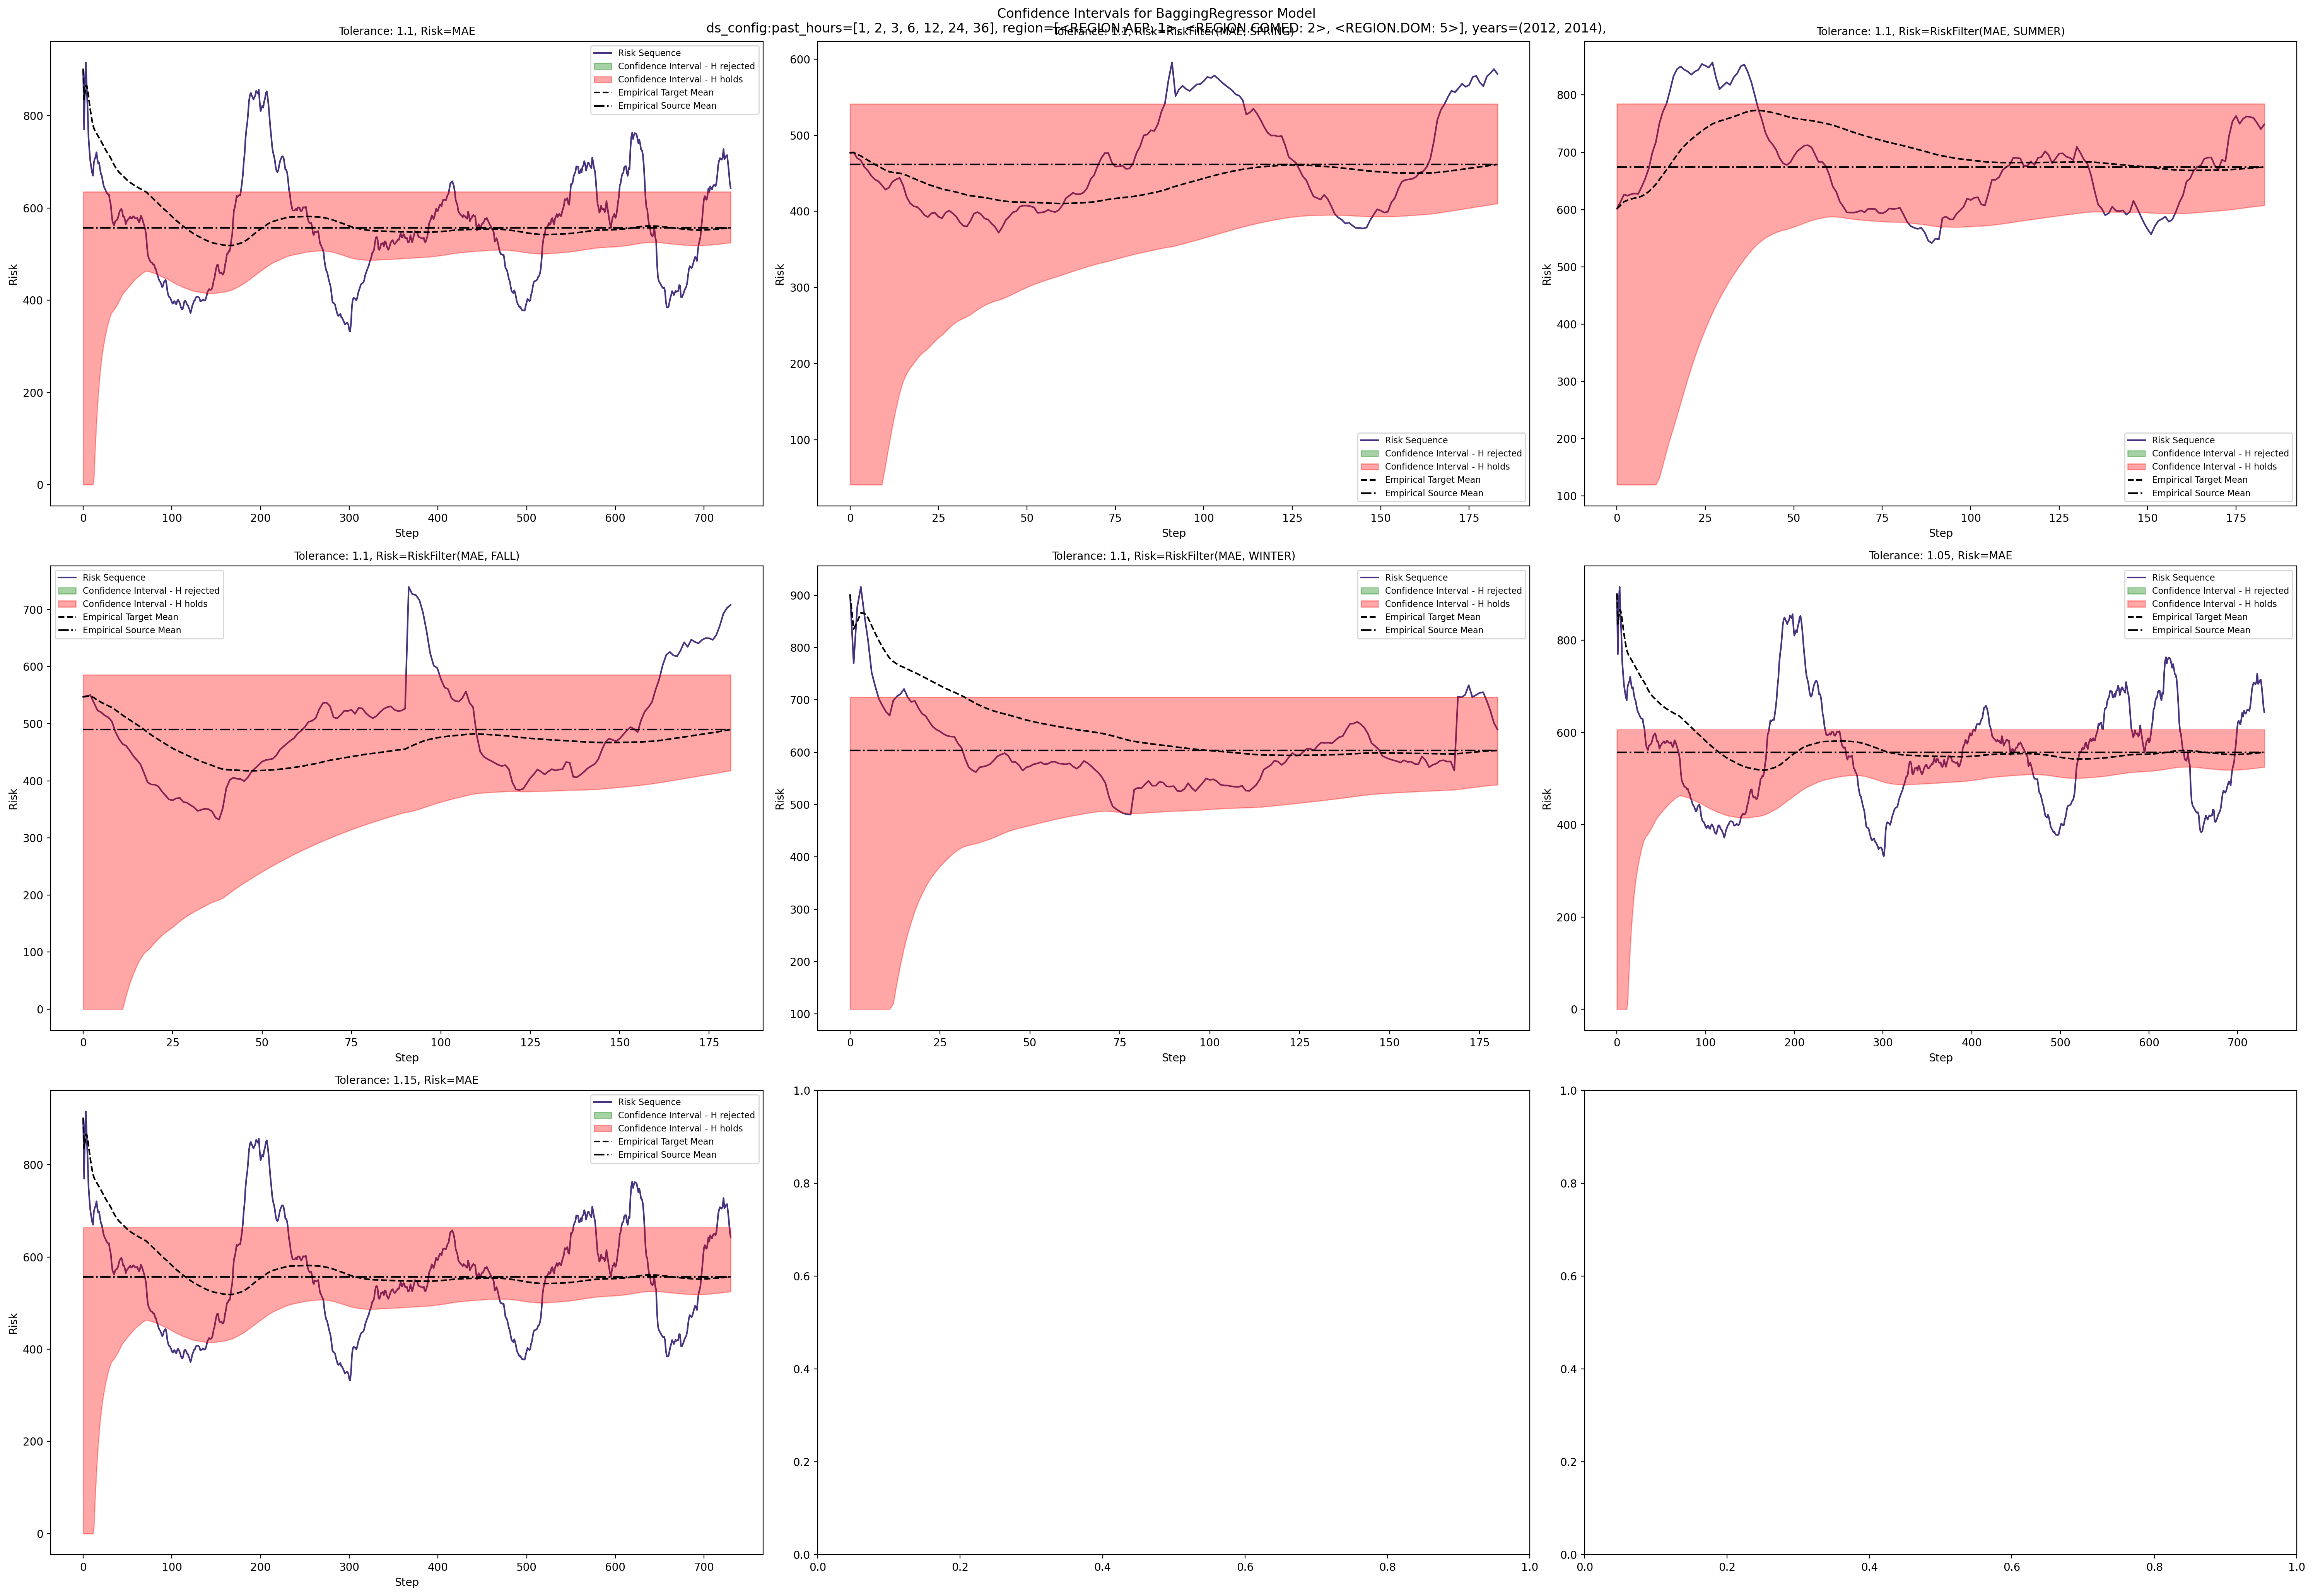

In [29]:
test_result = run_experiment(experiment, train_ds, retrain=False)

Testing:   0%|          | 0/365 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

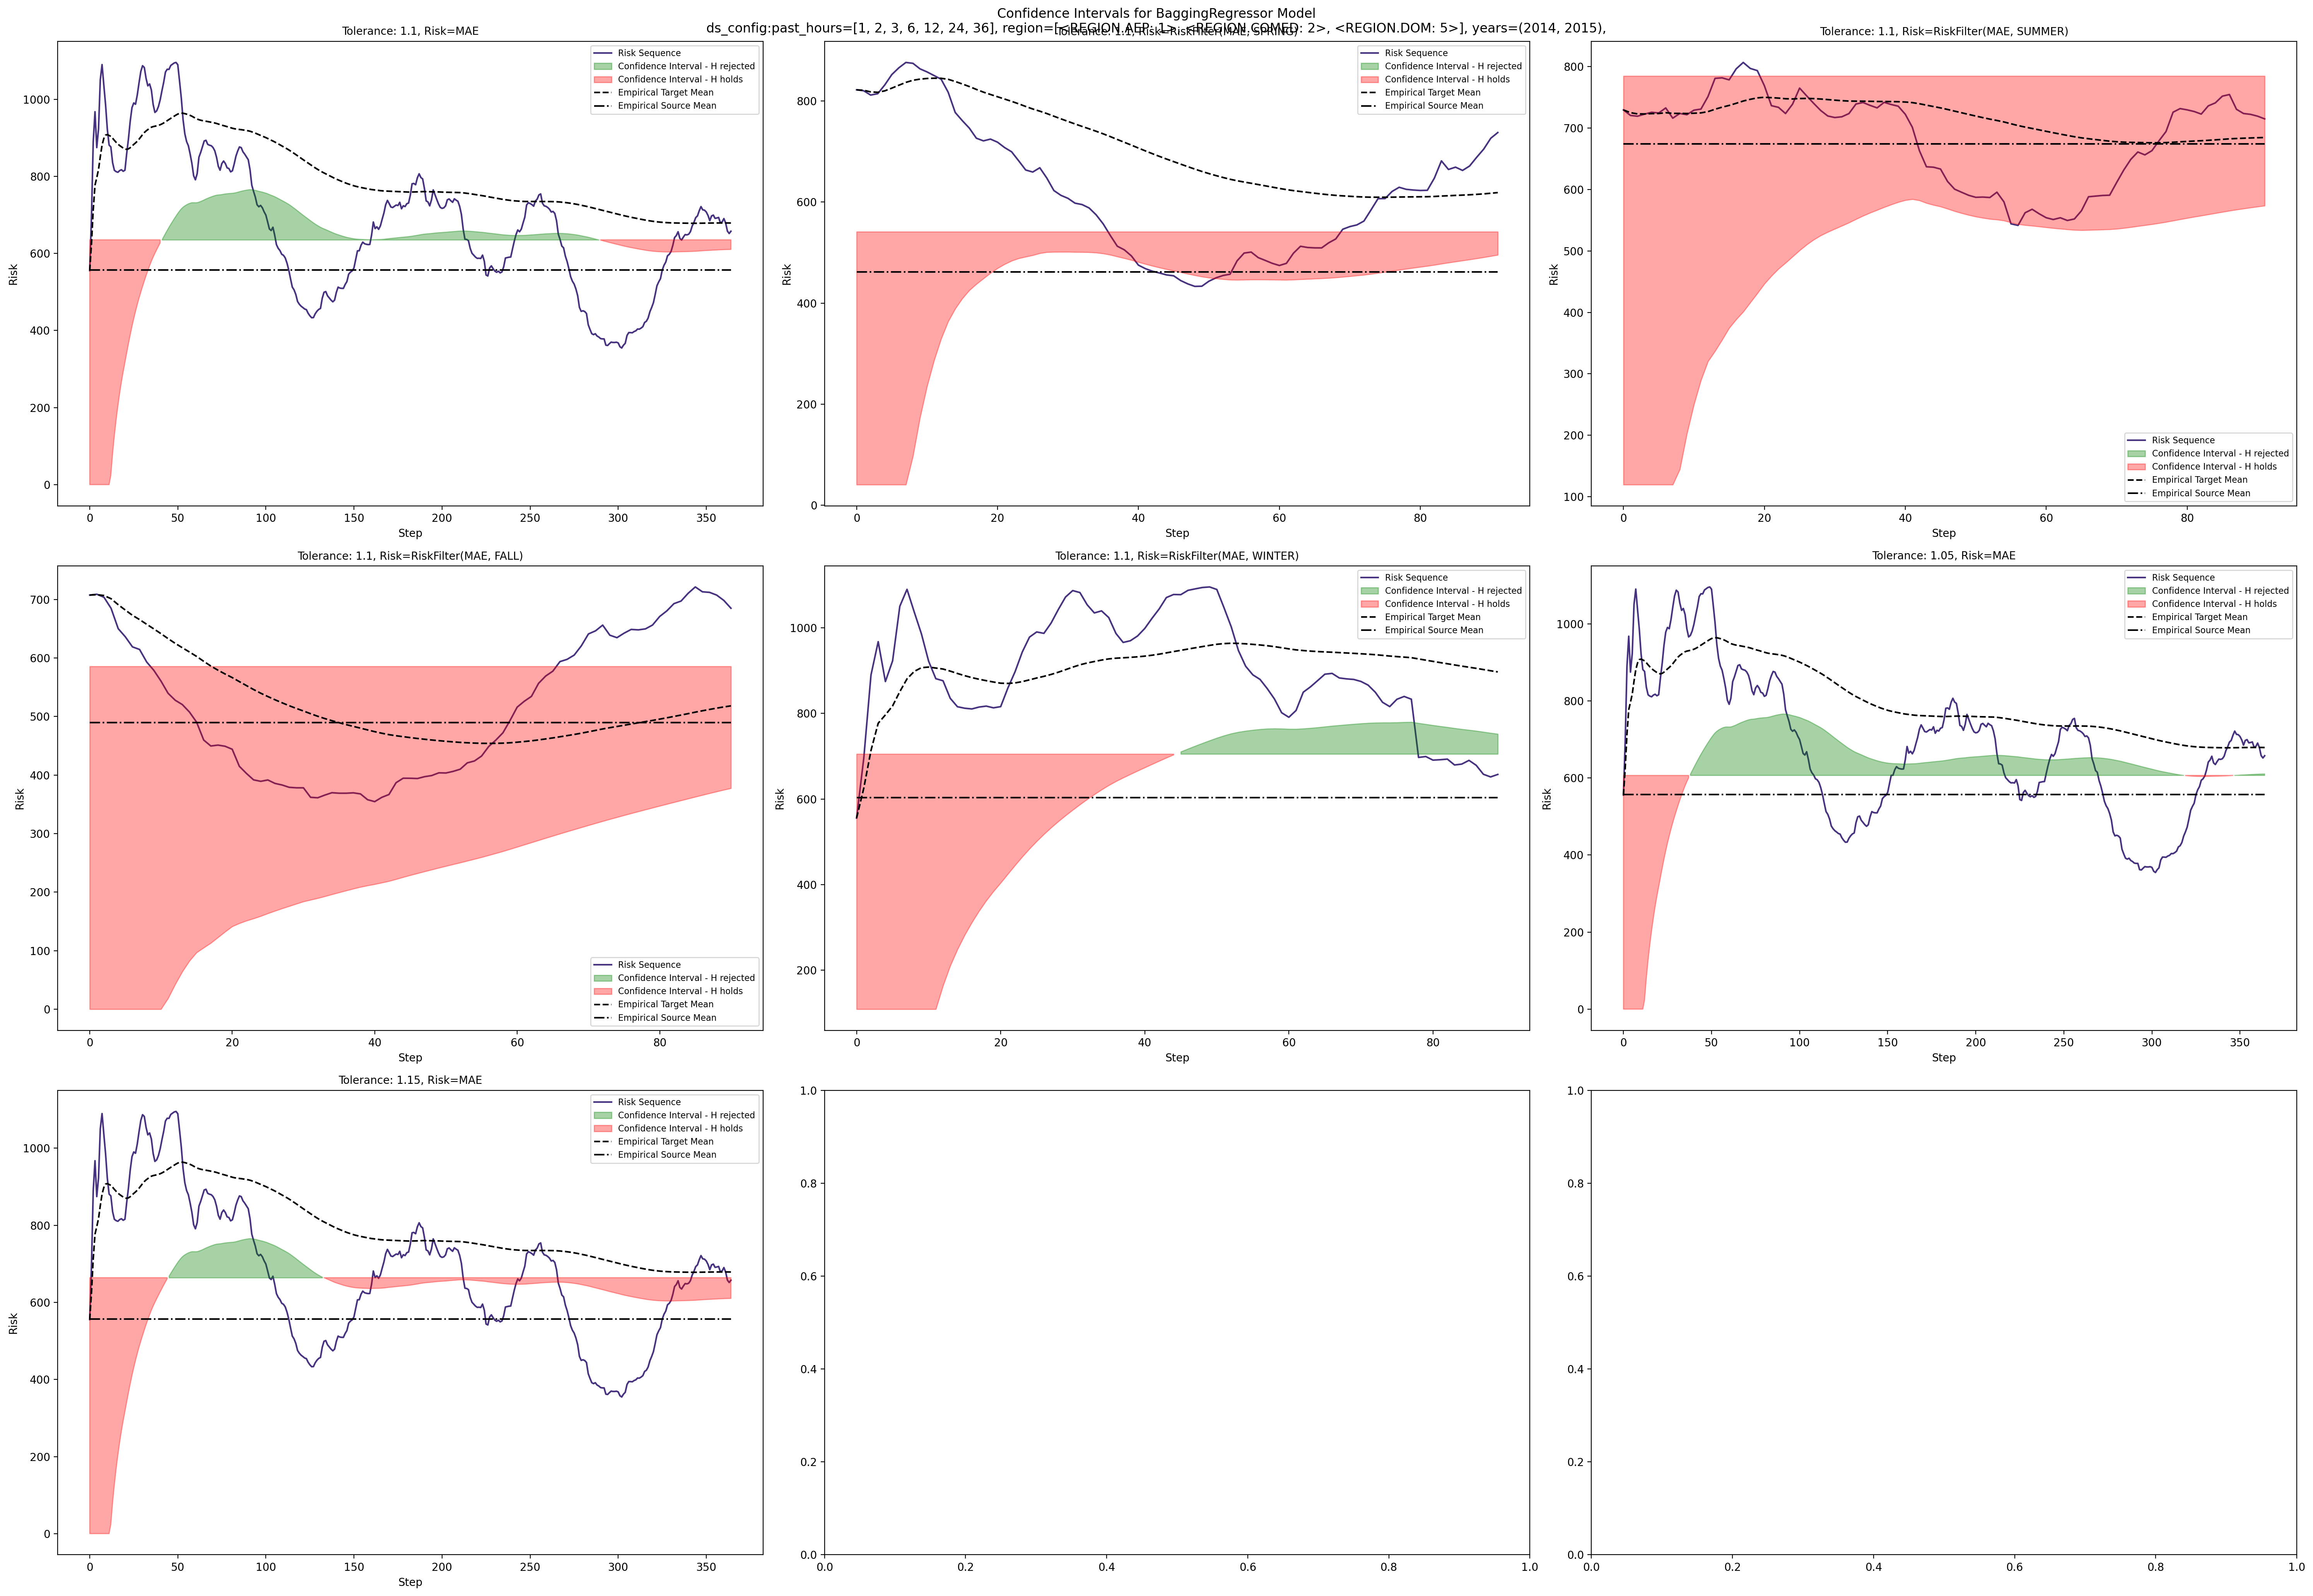

In [30]:
test_result = run_experiment(experiment, calibration_ds, retrain=False)

In [ ]:
test_result = run_experiment(experiment, calibration_ds, retrain=True)

Testing:   0%|          | 0/1675 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using ba

Clipping x to [109.21160125732422, 1287.5319290161133]
Clipping x to [109.21160125732422, 1287.5319290161133]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]
Clipping x to [40.82233428955078, 926.9394760131836]


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using ba

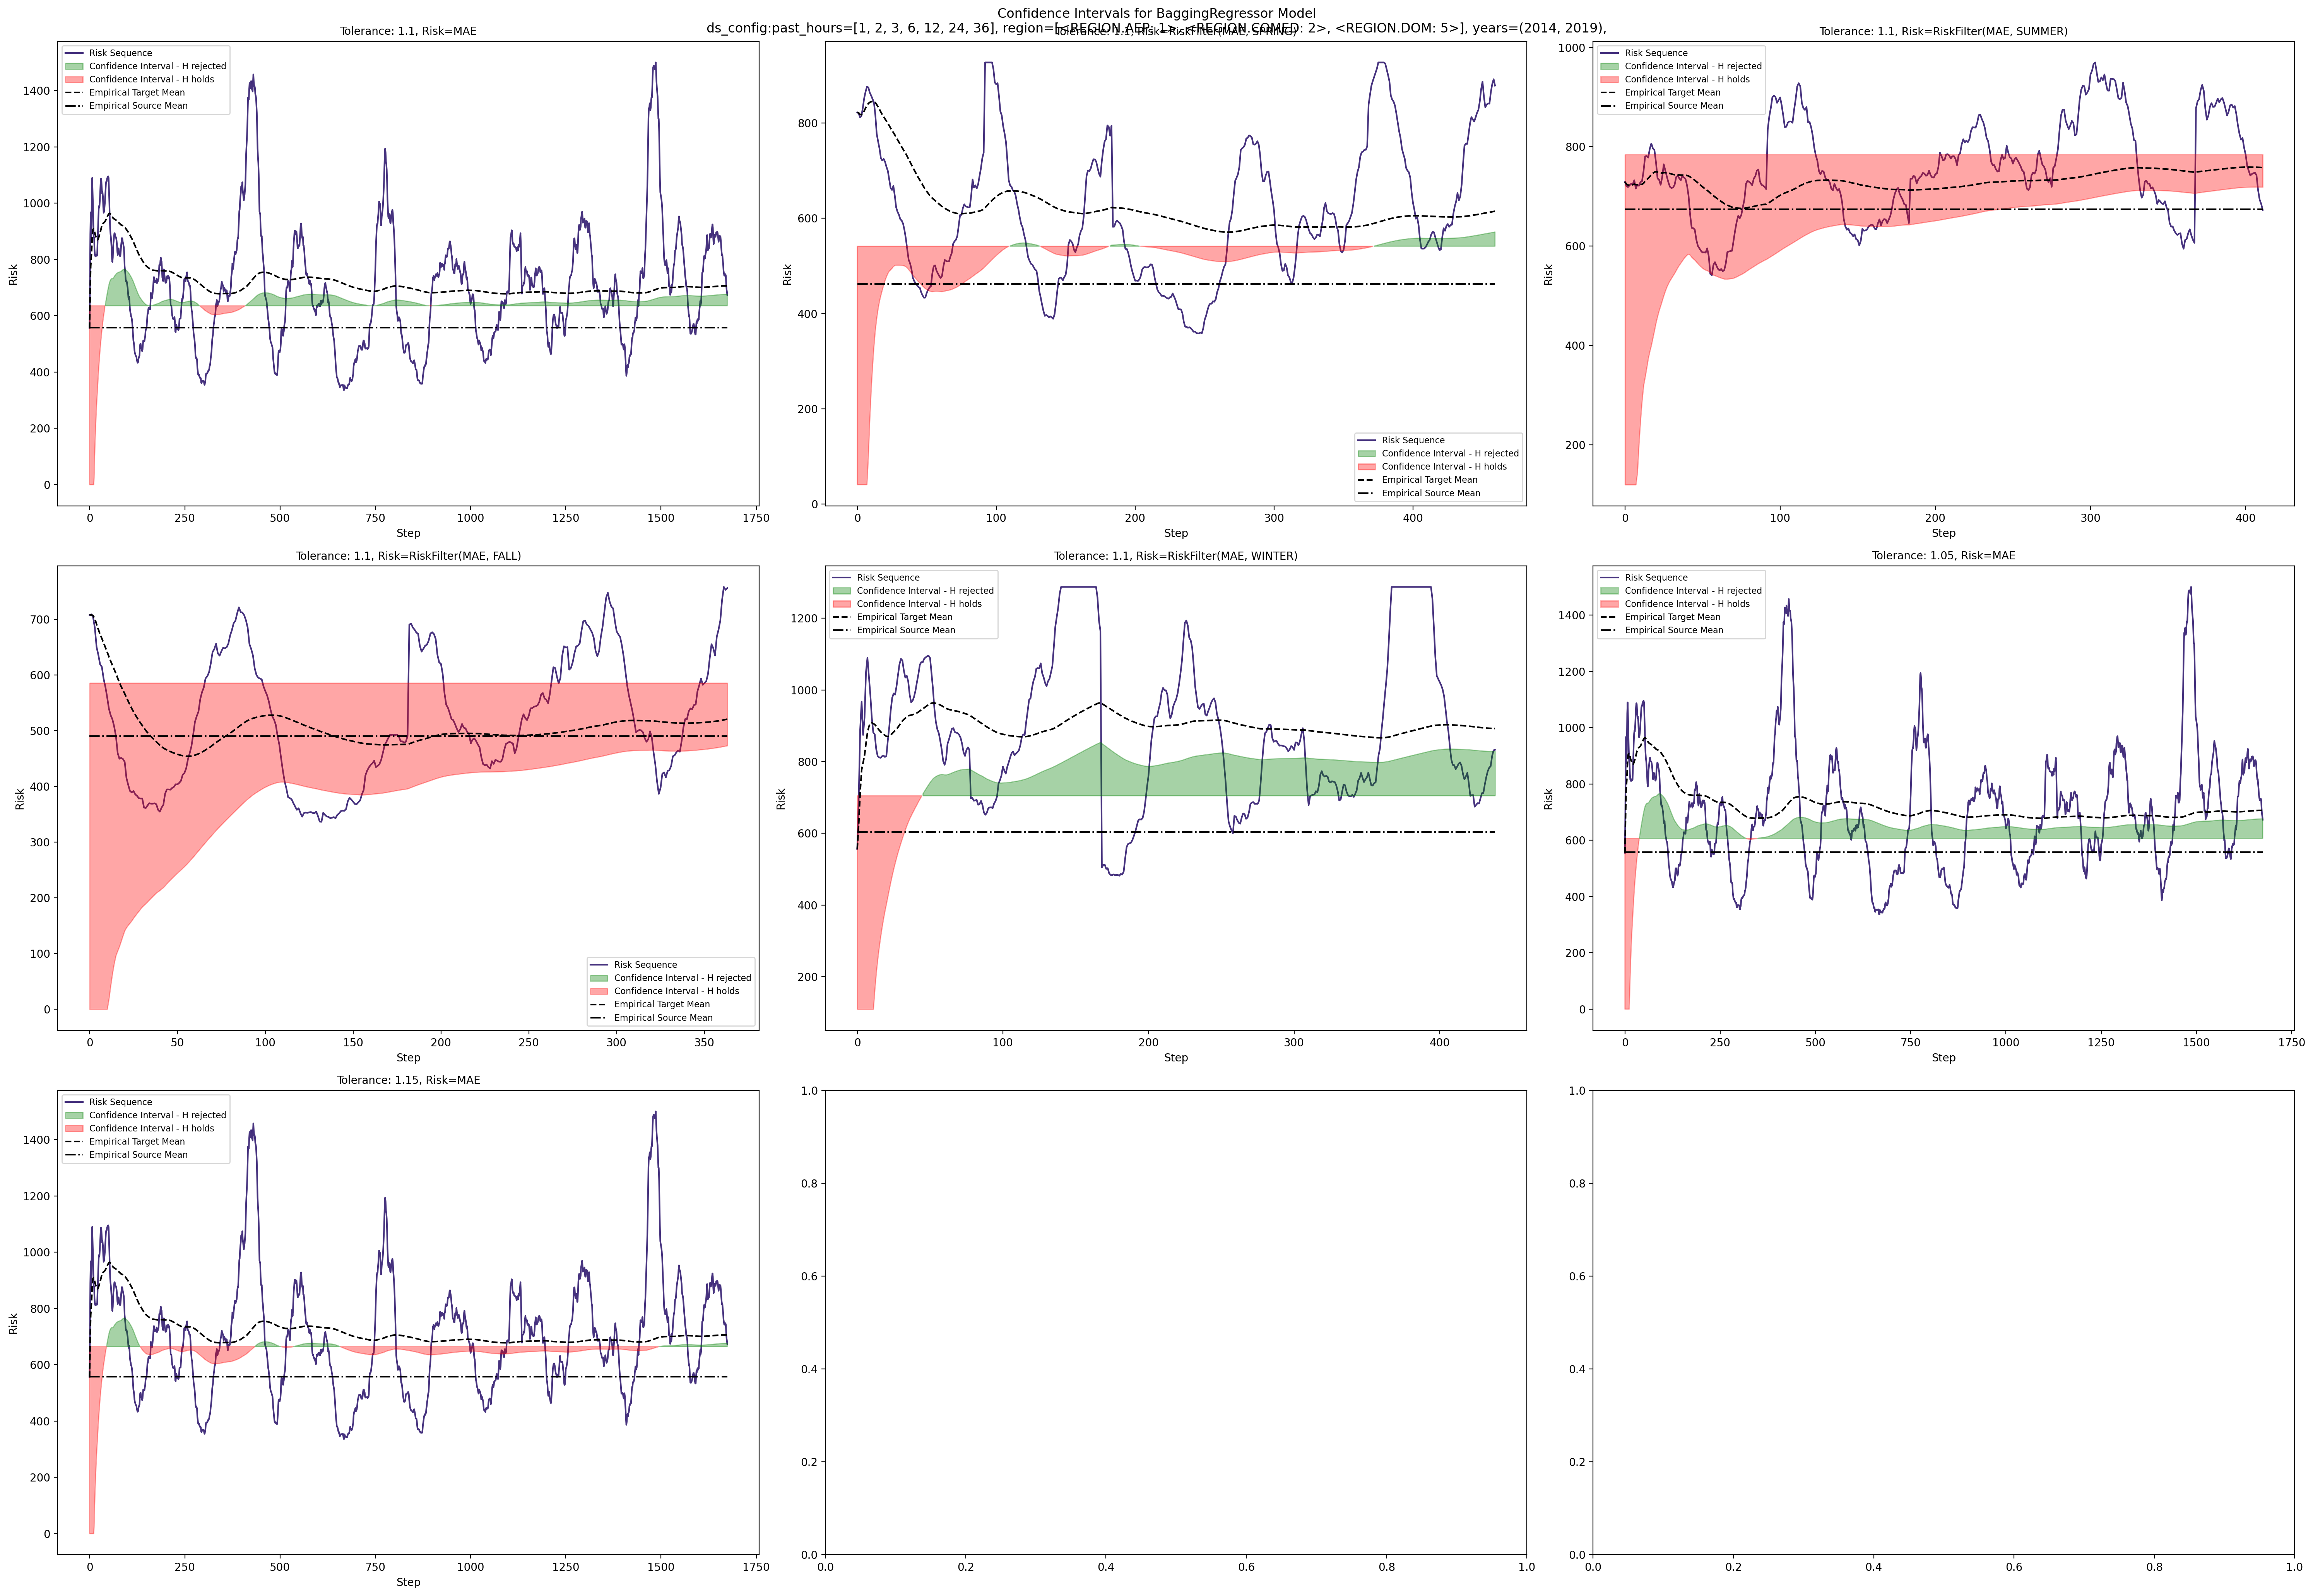

In [31]:
# experiment.train(train_ds)
test_cfg = DatasetConfig(**train_config.__dict__)
test_cfg.years = (2014, 2019)
test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=False)

Testing:   0%|          | 0/1675 [00:00<?, ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Don

retrain threshold crossed at index:  7128
train_features shape: (56939, 14), train_labels shape: (56939,)
Iteration 1, loss = 11526732.81793978
Iteration 1, loss = 98376716.11071987
Iteration 1, loss = 47259647.17610782
Iteration 1, loss = 9755282.76779320
Iteration 1, loss = 38240539.04361297
Iteration 2, loss = 878047.24118425
Iteration 2, loss = 7275894.03508218
Iteration 2, loss = 937202.49089442


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Iteration 2, loss = 797991.49409655
Iteration 2, loss = 8340780.23251659
Iteration 3, loss = 1108768.18522315
Iteration 3, loss = 731662.67920671
Iteration 3, loss = 756407.30075886
Iteration 3, loss = 4279378.04915365
Iteration 3, loss = 658467.71035542
Iteration 4, loss = 907465.62870433
Iteration 4, loss = 714622.37618178
Iteration 4, loss = 693229.46301364
Iteration 4, loss = 2169930.46885084
Iteration 4, loss = 642841.78132834
Iteration 5, loss = 826079.61240511
Iteration 5, loss = 705967.92262077
Iteration 5, loss = 662238.96792352
Iteration 5, loss = 1183651.05089173
Iteration 5, loss = 635249.52653373
Iteration 6, loss = 794096.43121999
Iteration 6, loss = 697002.18428463
Iteration 6, loss = 644031.30680814
Iteration 6, loss = 900911.09188975
Iteration 6, loss = 626249.96584929
Iteration 7, loss = 779016.72738565
Iteration 7, loss = 687183.36656532
Iteration 7, loss = 630797.98553343
Iteration 7, loss = 830885.87152359
Iteration 7, loss = 615957.29247521
Iteration 8, loss = 676

/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 98, loss = 268155.37443273
Iteration 94, loss = 279492.17518337
Iteration 99, loss = 273526.30011604
Iteration 99, loss = 283390.89758781
Iteration 99, loss = 267619.92704872
Iteration 95, loss = 276360.71034912
Iteration 100, loss = 273128.04052773
Iteration 100, loss = 283119.44057567
Iteration 100, loss = 267134.12680135
Iteration 96, loss = 274153.09610003


/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.2s
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 97, loss = 273004.00891087
Iteration 98, loss = 272083.13170631
Iteration 99, loss = 271299.02558244
Iteration 100, loss = 270640.69397769
Retrained Model with new data 


/home/guycoh/miniconda3/envs/rel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Par

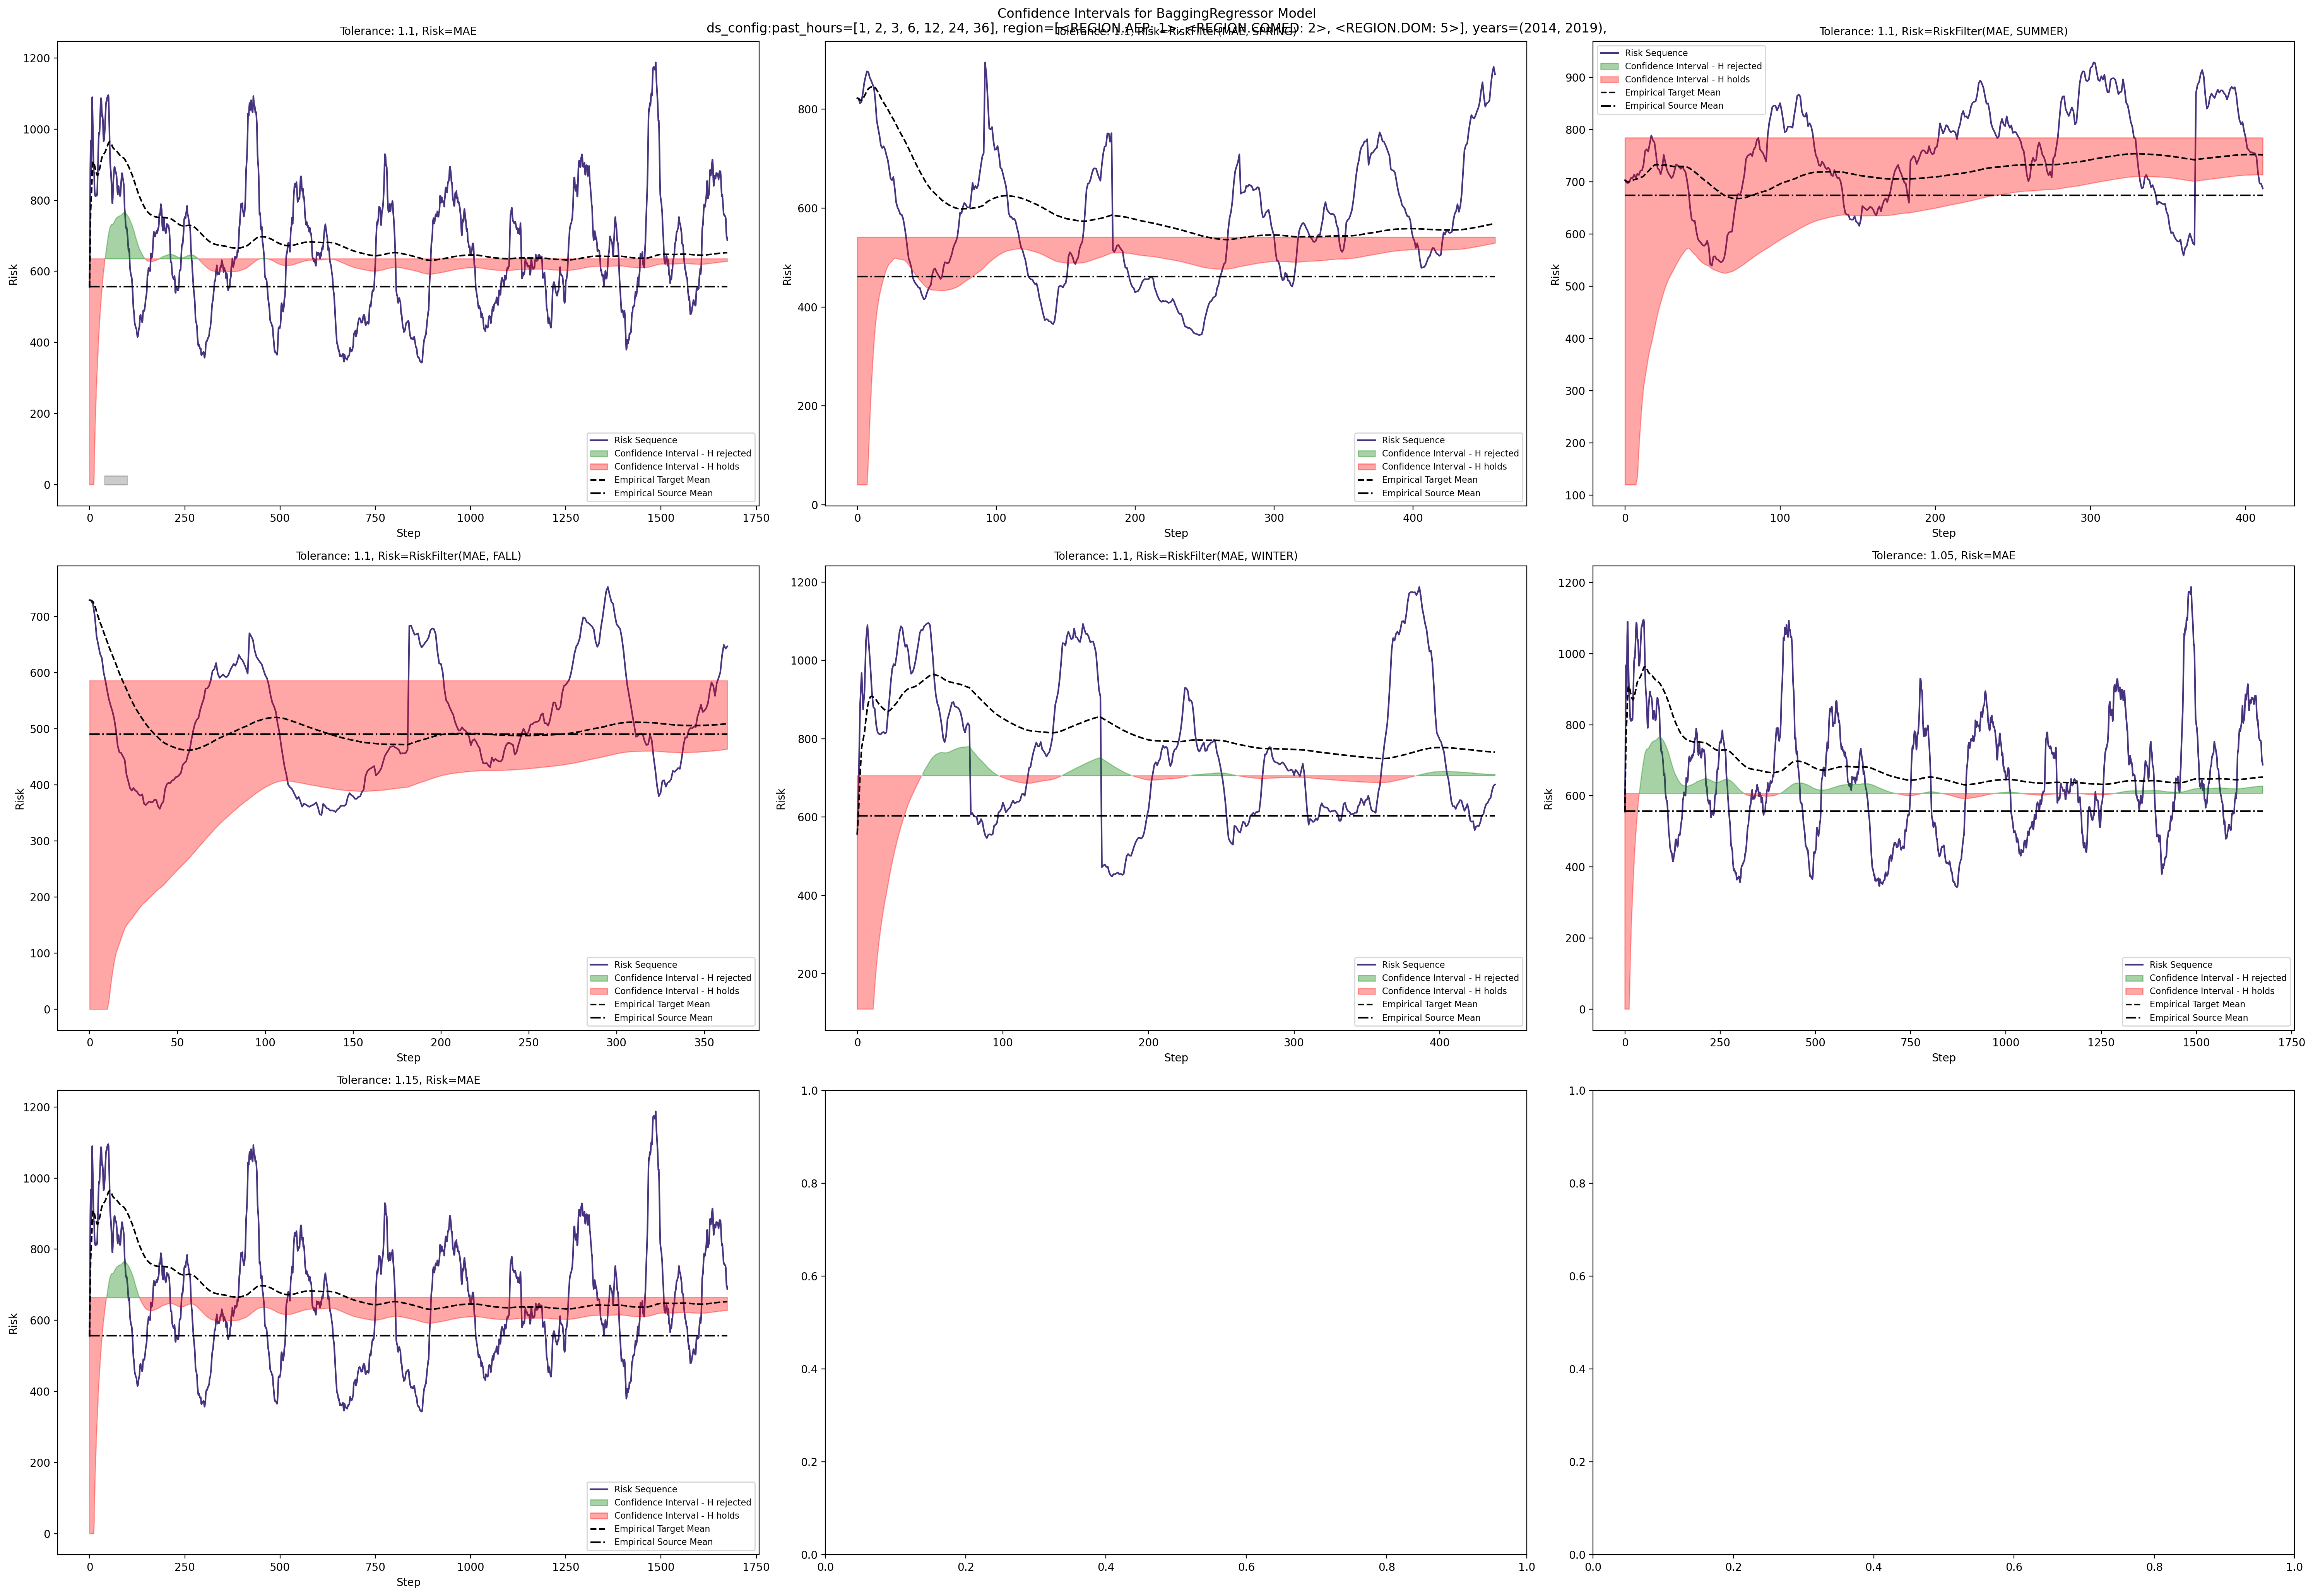

In [32]:
# experiment.train(train_ds)
test_cfg = DatasetConfig(**train_config.__dict__)
test_cfg.years = (2014, 2019)
test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=True)

In [ ]:
test_cfg = DatasetConfig(**train_config.__dict__)
test_cfg.region = [REGION.NI]
test_cfg.years = (2007, 2010)
# test_cfg.years = (2014, 2019)
test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=False)

In [ ]:
test_cfg = DatasetConfig(**train_config.__dict__)
test_cfg.region = [REGION.NI]
test_cfg.years = (2007, 2010)
test_ds = EnergyDataset(all_paths, test_cfg)
test_result = run_experiment(experiment, test_ds, retrain=True)

In [ ]:
# experiment.model.hyp_tests[0][0].plot()
# ax_gen_list = [SubplotGenerator(3, 2) for _ in range(len(model.hyp_tests))]
print("Train Config:")
print(train_config.__dict__)
for season in list(SEASON):
    config = DatasetConfig(**train_config.__dict__)
    config.season = [season] if season is not None else None
    # config.years = (2014, 2019)
    print("Test Config:")
    print(config)
    dataset = EnergyDataset(all_paths, config)
    print(dataset.features_df.shape)
    result = run_experiment(experiment, dataset)
    plt.show()
    # result = experiment.test(dataset)
    # for hyp, test_risk in experiment.model.hyp_tests:
    #     # ax = ax_gen.__next__()
    #     g = hyp.plot(layout='constrained')
    #     g.set_title(f"Tolarance: {hyp.tolerance}, Risk={test_risk}, Season={config.season}", fontsize=10)
    #     g.legend(fontsize=8)  # Adjust legend font size and position

    #     g.autoscale(enable=True, axis='both')
    #     plt.show()
    
    # experiment.model.reset(source=False, target=True)

# plt.tight_layout(pad=2,rect=[0.1, 0.1, 0.9, 0.9])
plt.show()

In [30]:
experiment.model.reset(source=False, target=True)

In [ ]:
import time
while True:
    time.sleep(1)

# OLD

In [2]:
settings = TrainConfig(
        # loss_fn = 'bce', # str
        # optimizer = 'adam', # str
        device = f"gpu", # str
        log = False, # bool
        logs_dir = "logs/", # str
        num_epochs = 30, # int
        checkpoints = 'test.pt', # str
        early_stopping = None, # int
        log_every = 1, # int
        timeout = "00:12:00:00", # int
        # learning_rate = 0.001, # float
        # weight_decay = 1e-06, # float
        batch_size = 2048, # int
        shuffle = False, # bool
        num_workers = 9, # int
        # train_test_split = 0.5, # float
    )

In [ ]:
path = "Hourly_Energy_Consumption/AEP_hourly.csv"
past_hours = 2

prper = DataPrep(path)
data = prper.data

# train_years = range(2004, 2016)
# val_years = range(2016, 2018)

def year_cond(start:int, end:int):
    return lambda data: data['Year'].between(start, end)

def season_cond(season:SEASON):
    return lambda data: data['Season'] == season.value

def month_cond(month:int):
    return lambda data: data['Month'] == month

def cond_and(conds:list):
    def cond(data):
        mask = pd.Series(len(data)*[True])
        for c in conds:
            mask = mask & c(data)
        return mask
    # return lambda data: ([cond(data) for cond in conds])
    return cond

train_conds = [year_cond(2006, 2008), season_cond(SEASON.WINTER)]
val_conds = [year_cond(2009, 2012), season_cond(SEASON.SUMMER)]

train_ds = EnergyDataset(path, past_hours=past_hours, condition=cond_and(train_conds))
val_ds = EnergyDataset(path, past_hours=past_hours, condition=cond_and(val_conds))


datamodule = DataModule(train_ds,
                        val_ds,
                        batch_size=settings.batch_size,
                        num_workers=settings.num_workers,
                        shuffle=settings.shuffle,
                        seed=42,
                        )


In [ ]:
train_ds.labels_df

In [ ]:
train_ds.data_df

In [ ]:
train_ds[0]

In [9]:
# datamodule.prepare_data()
dl = datamodule.train_dataloader()

In [10]:
batch, label = next(iter(dl))
n_features = batch.shape[-1]

In [ ]:
batch.shape, label.shape

In [31]:
from torch import Tensor


class ResidMLP(LightningModel):
    def __init__(self, input_size, hidden_size, output_size=1, loss:nn.Module=nn.L1Loss()):
        super().__init__(loss)
        # self.f = nn.TransformerEncoderLayer(input_size,
        #                                     nhead=4,
        #                                     dim_feedforward=hidden_size[-1],
        #                                     dropout=0.1,
        #                                     activation='relu',
        #                                     batch_first=True)
        
        # self.rmlp = RMLP(
        #     in_dim=input_size,
        #     block_in_dim=hidden_size[0], 
        #     block_dims=hidden_size,
        #     block_nonlins=[nn.ReLU()]*len(hidden_size),
        #     n_blocks=2,
        #     out_dim=output_size,
        #     out_nonlin=nn.Identity(),
        #     batch_norm=False,
        #     )
        # self.mlp = MlpBlock(
        #     in_dim=input_size,
        #     dims=hidden_size,
        #     nonlins=[nn.Tanh()]*len(hidden_size),
        #     batch_norm=False,
        #     )
        self.out_layer = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        # x = x.flatten(1).to(torch.float32)
        # x = self.rmlp(x)
        # x = self.mlp(x)
        # x = self.f(x)
        return self.out_layer(x)#.squeeze(-1)
    
    def accuracy(self, preds: Tensor, labels: Tensor) -> Tensor:
        return (preds - labels).abs().mean()
    


In [ ]:
in_size = n_features#*past_hours
rmlp = ResidMLP(input_size=in_size, hidden_size=[24, 16], output_size=1)

model = LightningWrapper(rmlp)
print(model)

In [ ]:
trainer = LightningTrainer(settings, "global_wheat_1")
train_dl, val_dl = datamodule.train_dataloader(), datamodule.val_dataloader()
trainer.fit(model, dl_train=train_dl, dl_test=val_dl)


In [10]:
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor

In [11]:
rf = RandomForestRegressor()


In [12]:
rf = rf.fit(train_ds.features, train_ds.labels)

In [13]:
def mae(preds, labels):
    return np.abs(preds - labels).mean()

In [17]:
train_scores = mae(rf.predict(train_ds.features), train_ds.labels.numpy())
val_scores = mae(rf.predict(val_ds.features), val_ds.labels.numpy())

In [69]:

def validate(model:RandomForestRegressor, val_dl):
    scores = []
    for batch, label in val_dl:
        score = np.abs(model.predict(batch.numpy()) - label.numpy()).flatten()
        scores.append(score)
    return np.concatenate(scores)

train_scores = validate(rf, train_dl)
val_scores = validate(rf, val_dl)
# scores = []
# for batch, label in val_dl:
#     score = np.abs(rf.predict(batch.numpy()) - label.numpy()).mean()
#     scores.append(score)
# print(np.mean(scores))

In [ ]:
print(f"train_score = {train_scores.mean()}")
print(f"val_score = {val_scores.mean()}")

In [ ]:
model(batch)